<a href="https://colab.research.google.com/github/nahbos/AUT-Neural-Networks/blob/main/HW07/HW07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### - Sobhan Moradian Daghigh
#### - 6/20/2022
#### - ANN - HW07

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf, keras
import tensorflow_datasets as tfds
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPool2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import SGD
from copy import copy


import warnings
warnings.filterwarnings("ignore")
import itertools
%load_ext tensorboard
import os

In [2]:
print(tf.__version__)

2.8.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/logs', histogram_freq=1)

In [5]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = 0
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    current_acc = logs.get('accuracy')
    if np.less(self.best, current_acc):
      self.best = current_acc
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if np.greater_equal(self.wait, self.patience):
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

In [6]:
es_callback = EarlyStoppingCallback(patience=3)

In [7]:
# return dataset.cache().map(lambda img, label: (tf.cast(tf.image.resize(img, (IMAGE_RES, IMAGE_RES)), tf.float32), label)).batch(BATCH_SIZE).prefetch(1)
# return dataset.cache().map(lambda img, label: ((tf.cast(tf.reshape(tf.image.resize(img, (IMAGE_RES, IMAGE_RES)), [-1]), tf.float32) - 127.5) / 127.5, label)).batch(BATCH_SIZE).prefetch(1)

In [13]:
BATCH_SIZE = 16
IMAGE_RES = 224

In [9]:
def data_preprocess(dataset):
  return dataset.cache().map(lambda img, label: ((tf.cast(tf.image.resize(img, (IMAGE_RES, IMAGE_RES)), tf.float32) - 127.5) / 127.5, label)).batch(BATCH_SIZE).prefetch(1)

In [10]:
def load_data():
  name = 'cats_vs_dogs'
  setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
  train, validation, test = tfds.load(name, split = ('train[:70%]', 'train[70%:80%]', 'train[80%:]'), as_supervised=True, batch_size=BATCH_SIZE)
  print('  |_ {} loaded'.format(name))
  return train, validation, test

In [11]:
train, validation, test = load_data()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZKB9XP/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
  |_ cats_vs_dogs loaded


In [14]:
train = data_preprocess(train)
validation = data_preprocess(validation)
test = data_preprocess(test)

In [15]:
len(test)

19

hrer
(16, 224, 224, 3)


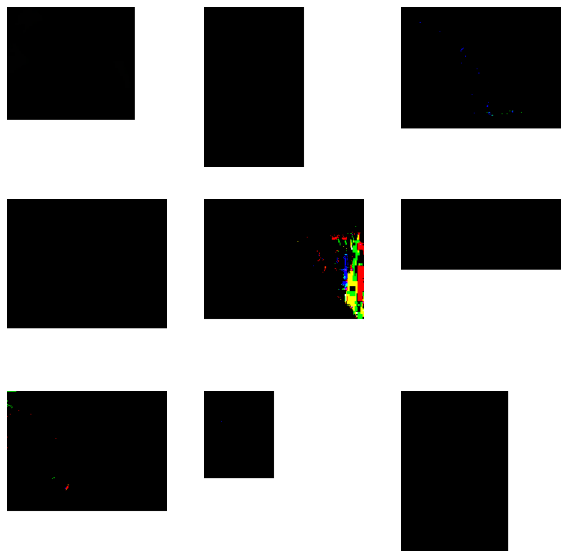

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  print('hrer')
  images = images[15]
  print(images.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
len(train) * 16

1024

### Defining a few hyperparameters

In [27]:
# Consistent results
np.random.seed(10)

noise_dim = 100

steps_per_epoch = len(train)
epochs = 5

img_rows, img_cols, channels = 224, 224, 3

optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [20]:
def create_generator():
    generator = Sequential()

    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense((IMAGE_RES * IMAGE_RES * 3), activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [21]:
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [22]:
discriminator = create_descriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 150528)            154973952 
                                                                 
 sequential (Sequential)     (None, 1)                 154798081 
                                                                 
Total params: 309,772,033
Trainable params: 154,973,952
Non-trainable params: 154,798,081
_________________________________________________________________


In [30]:
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(image.reshape((img_rows, img_cols, channels)).astype(np.uint8))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [24]:
np.random.randint(0, len(train), size=BATCH_SIZE)

array([ 9, 61, 36, 15,  0, 49, 59, 28, 25, 29, 48, 29, 49, 58,  8,  9])

(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
(16, 150528)
Epoch: 0 	 Discriminator Loss: 10.459249496459961 		 Generator Loss: 0.07605061680078506


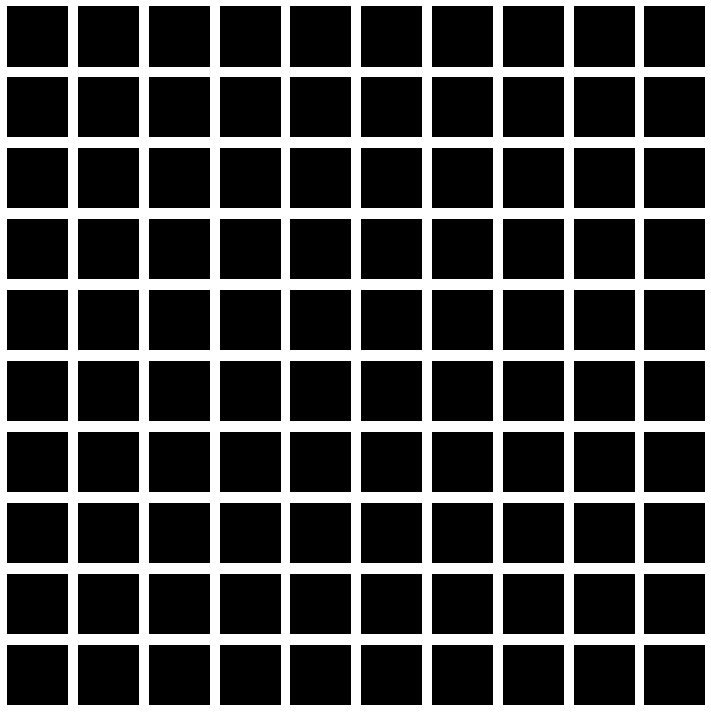

(16, 150528)


KeyboardInterrupt: ignored

In [32]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

for images, labels in train.take(1):
  

for epoch in range(epochs):
    for batch in range():
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
        fake_x = generator.predict(noise)
        print(np.array(fake_x).shape)

        real_x = []
        for batch_i in range(BATCH_SIZE):
            images_in_batch = images[batch_i]
            real_x.append(tf.reshape(images_in_batch[np.random.randint(0, BATCH_SIZE)], [-1]))

        print(np.array(real_x).shape)

        x = np.concatenate((real_x, fake_x))


        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    show_images(static_noise, epoch)